# Project  2 - Continuous Control from the Deep Reinforcement Learning Nanodegree of Udacity

The task is to train an agent to maintain the position of a double-jointed arm at a moving target location for as many time steps as possible. The task is continuous, although the episodes end after a certain time.

A reward of 0.1 is provided for each step that the agent's hand is in the goal location. In order to solve the environment, the agent must pick an average score of 30+ over 100 consecutive episodes. 


## 1. Essentials of the environment and the agent

We begin by importing some necessary packages and starting the Unity environment provided by Udacity. Environments contain *_brains_*, which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent
import torch

env = UnityEnvironment(file_name='/home/pedro/codes/p2_continuous-control/Reacher_Linux/Reacher.x86_64')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. 

Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector must be a number between -1 and 1. This constraint is included in the code of the agent.

Next we start the environment and agent, and load saved waits, in order to watch an agent acting in an episode. This section can be skipped if the reader is already familiar with the setup, or it can be used to evaluate the trained agent (although for some reason I have not been able to figure out, the score here is lower than when training).

In [18]:
env_info = env.reset(train_mode=False)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

agent = Agent(state_size, action_size)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

score = 0                   
while True:
    action = agent.act(state, add_noise=False)
    env_info = env.step([action])[brain_name]           
    next_state = env_info.vector_observations[0]
    reward = env_info.rewards[0]                         
    done = env_info.local_done[0]
    agent.step(state, action, reward, next_state, done)
    score += reward                       
    state = next_state                               
    if done:                                  
        break

print('Total score in this episode: {}'.format(score))

Total score in this episode: 6.129999862983823


# 2. Training

Here we train the agent using the action/reward feedback loop characteristic of reinforcement learning. Details on the agent and its underlying model are to be found in the accompanying files, and are discussed in the report.

Episode 307	Score 36.61	Average Score 30.07
Environment solved in 307 episodes!	Average Score: 30.07


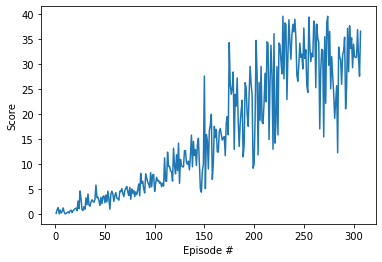

In [13]:
def ddpg(n_episodes=1000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        agent.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step([action])[brain_name]
            next_state = env_info.vector_observations[0]         
            reward = env_info.rewards[0]                         
            done = env_info.local_done[0]                        
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tScore {:.2f}\tAverage Score {:.2f}'.format(i_episode, score, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if np.mean(scores_deque) > 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            break            
    return scores

env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)
agent = Agent(state_size, action_size)

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()